# Backdoor Unlearning

## Outline

1. Experimental setup (generating configs)
2. Clean model training
3. Poisoned model training
4. First-order unlearning
5. Second-order unlearning
6. Visualizing results


## Experimental Setup

- All configurations to test are defined in the `[train|poison|unlearn].json` files (see below).
- If parameters are passed as list, all their combinations are tested in a grid-search manner.
- Only a single combination is provided for this demo. The original combinations are in `Applications/Poisoning/configs`
- The function generates directories and configuration files for each combination. They are later used by an evaluation script to run the experiment. This allows for parallelization and distributed execution.

In [6]:
import sys
sys.path.append('../')

# only if you are using CUDA devices
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from conf import BASE_DIR
from Applications.Poisoning.gen_configs import main as gen_configs
from Applications.Poisoning.poison.poison_models import train_poisoned
from Applications.Poisoning.configs.demo.config import Config
from Applications.Poisoning.train import main as train
from Applications.Poisoning.unlearn.first_order import run_experiment as fo_experiment
from Applications.Poisoning.unlearn.second_order import run_experiment as so_experiment


In [7]:

model_folder = BASE_DIR/'models'/'poisoning'
train_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'train.json'
poison_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'poison.json'
unlearn_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'unlearn.json'

gen_configs(model_folder, train_conf, poison_conf, unlearn_conf)

## Clean Model Training

- Set configuration

In [8]:
# train one clean and one poisoned model
#dataset = 'Cifar10'
#dataset = 'Cifar100'
#dataset = 'Mnist'
dataset = 'FashionMnist'
modeltype = "VGG16"
classes= 10
#lasses = 100
#dataset = 'Mnist'

* Train a clean model for reference.

In [9]:
train(model_folder=model_folder/'clean', dataset=dataset, classes=classes, modeltype=modeltype)

2024-06-12 13:59:27.532204: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-12 13:59:27.532245: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: conite-HP
2024-06-12 13:59:27.532252: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: conite-HP
2024-06-12 13:59:27.532381: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 555.42.2
2024-06-12 13:59:27.532409: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 555.42.2
2024-06-12 13:59:27.532415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 555.42.2
2024-06-12 13:59:27.532679: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions i

Loading weights from None

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
 22/469 [>.............................] - ETA: 2:36 - loss: 2.0530 - accuracy: 0.5057

KeyboardInterrupt: 

In [ ]:
from Applications.Poisoning.evaluate import main as evaluate

clean_folder = model_folder/'clean'
clean_weights_name = dataset+'_'+modeltype+'_best_model.hdf5'
clean_weights = clean_folder/clean_weights_name
report_clean_model = evaluate(dataset, modeltype, clean_weights, clean_folder)

Loading weights from None
Model weights loaded successfully.
Accuracy FashionMnist model: 0.922


## Train Poisoned Model

- Select one of the generated configurations and train a poisoned model.
- The poisoning uses an `injector` object which can be persisted for reproducibility. It will inject the backdoors/label noise into the same samples according to a seed. In our experiments, we worked with label noise poisoning.

In [7]:

poisoned_folder = model_folder/'budget-10000'/'seed-42'
poison_kwargs = Config.from_json(poisoned_folder/'poison_config.json')
train_kwargs = Config.from_json(poisoned_folder/'train_config.json')


In [8]:
train_poisoned(model_folder=poisoned_folder, poison_kwargs=poison_kwargs, train_kwargs=train_kwargs, dataset=dataset, classes=classes, modeltype=modeltype)

Loading weights from None

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
469/469 [==============================] - 202s 430ms/step - loss: 1.5611 - accuracy: 0.4479 - val_loss: 0.9177 - val_accuracy: 0.7124 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
469/469 [==============================] - 217s 462ms/step - loss: 1.2277 - accuracy: 0.5149 - val_loss: 1.1335 - val_accuracy: 0.6200 - lr: 0.0010

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
469/469 [==============================] - 230s 490ms/step - loss: 1.1704 - accuracy: 0.5310 - val_loss: 0.8598 - val_accuracy: 0.7112 - lr: 0.0010

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
469/469 [==============================] - 227s 484ms/step - loss: 1.1421 - accuracy: 0.5436 - val_loss: 1.1905 - val_accuracy: 0.7488 - lr: 0.001

In [14]:
weights_name = dataset+'_'+modeltype+'_poisoned_model.hdf5'
fo_repaired_weights_file = dataset+'_'+modeltype+'_repaired_model.hdf5'
so_repaired_weights_file = dataset+'_'+modeltype+'_repaired_model.hdf5'
poisoned_weights = poisoned_folder/weights_name     # model that has been trained on poisoned data
fo_repaired_weights = poisoned_folder/'first-order'/fo_repaired_weights_file   # model weights after unlearning (first-order)
so_repaired_weights = poisoned_folder/'second-order'/so_repaired_weights_file   # model weights after unlearning (second-order)
injector_path = poisoned_folder/'injector.pkl'             # cached injector for reproducibility
clean_results = model_folder/'clean'/'train_results.json'  # path to reference results on clean dataset


In [11]:
#Poisonned models
evaluate(dataset, modeltype, poisoned_weights, poisoned_folder)
# dataframe

Loading weights from None
Model weights loaded successfully.
Accuracy FashionMnist model: 0.916


In [22]:
print(report)

None


## Unlearning

- Perform the first-order and second-order unlearning. The unlearning is wrapped in a function that
    - loads the clean data, saves the original labels
    - injects the poison (label noise)
    - creates difference set Z using `injector.injected_idx`
    - main unlearning happens in `Applications.Poisoning.unlearn.common.py:unlearn_update` and the thereby called `iter_approx_retraining` method
- The variable naming follows the following ideas:
    - `z_x`, `z_y`: features (x) and labels (y) in set `Z`
    - `z_x_delta`, `z_y_delta`: changed features and labels (`z_x == z_x_delta` here and `z_y_delta` contains the original (fixed) labels)
- A word about why iterative:
    - The approximate retraining is configured to unlearn the desired changes in one step.
    - To avoid putting a lot of redundant erroneous samples in the changing set `Z`, the iterative version
        - takes a sub-sample (`prio_idx`) of `hvp_batch_size` in the delta set `Z`
        - makes one unlearning step
        - recalculates the delta set and focuses only on remaining errors
    - The idea here is that similar to learning, it is better to work iteratively in batches since the approximation quality of the inverse hessian matrix decreases with the number of samples included (and the step size)

Loading weights from None
Loading weights from None


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

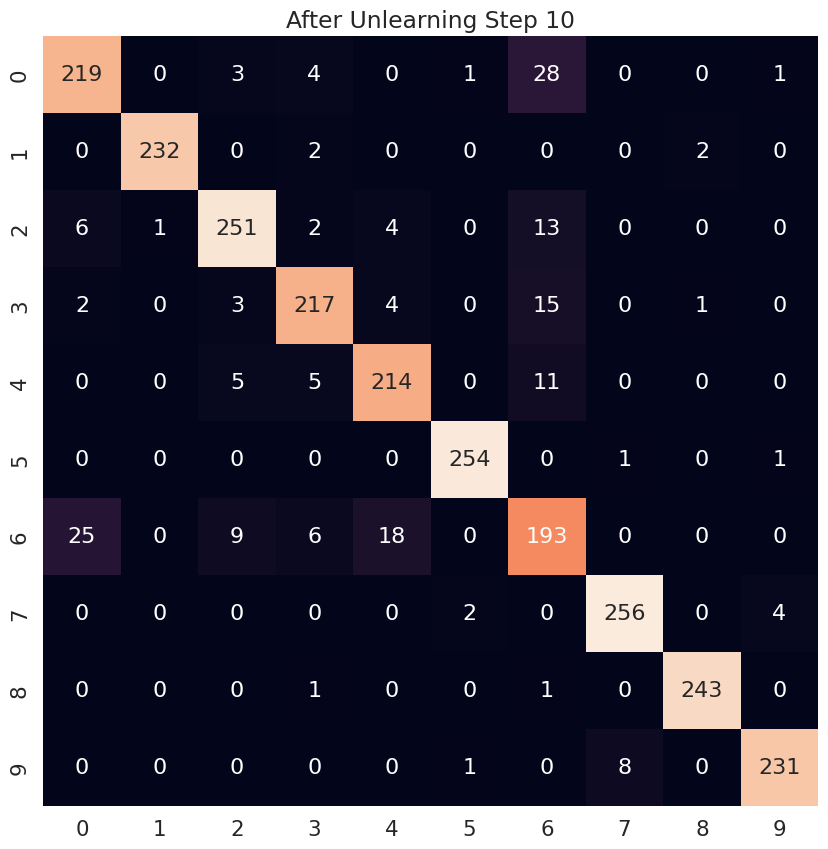

In [12]:

fo_unlearn_kwargs = Config.from_json(poisoned_folder/'first-order'/'unlearn_config.json')
so_unlearn_kwargs = Config.from_json(poisoned_folder/'second-order'/'unlearn_config.json')

fo_experiment(dataset, modeltype, poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs)

In [5]:
evaluate(dataset, modeltype, fo_repaired_weights, poisoned_folder/'first-order')

NameError: name 'evaluate' is not defined

In [16]:
so_experiment(dataset, modeltype, poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs)

Loading weights from None
Early stopping at iteration 464. Update norm 304187.4211502075 > [297472.08571624756, 20]
Early stopping at iteration 224. Update norm 482742.1805419922 > [460052.504776001, 20]
Early stopping at iteration 126. Update norm 768438.3790893555 > [762441.8203735352, 20]
Early stopping at iteration 172. Update norm 1229380.2811279297 > [1183058.8435058594, 20]
Early stopping at iteration 139. Update norm 1708718.3527832031 > [1598740.2150878906, 20]
Early stopping at iteration 157. Update norm 1197252.5047607422 > [1167484.614807129, 20]
Early stopping at iteration 181. Update norm 1317225.3913574219 > [1173573.1642456055, 20]
Early stopping at iteration 178. Update norm 1725046.2987670898 > [1673772.4096679688, 20]
Early stopping at iteration 95. Update norm 1363841.4137573242 > [1214101.3397827148, 20]


## Visualizing the Results

- To give some notion of how well the unlearning worked, we plot confusion matrices before and after unlearning.
- This is just an example and not required for unlearning.

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

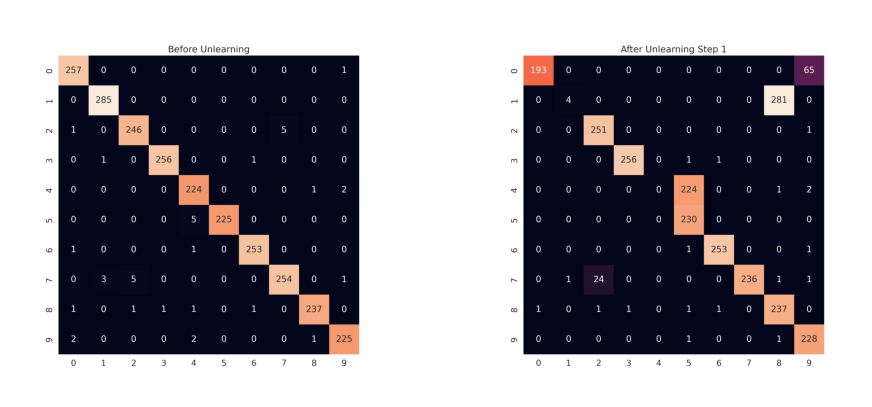

In [26]:
cm_before = mpimg.imread(poisoned_folder/'first-order'/'cm'/'cm_unlearning_00.png')
cm_after = mpimg.imread(poisoned_folder/'first-order'/'cm'/'cm_unlearning_01.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cm_before)
ax[1].imshow(cm_after)
ax[0].grid(False)
ax[1].grid(False)
ax[0].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
ax[1].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)

plt.show()

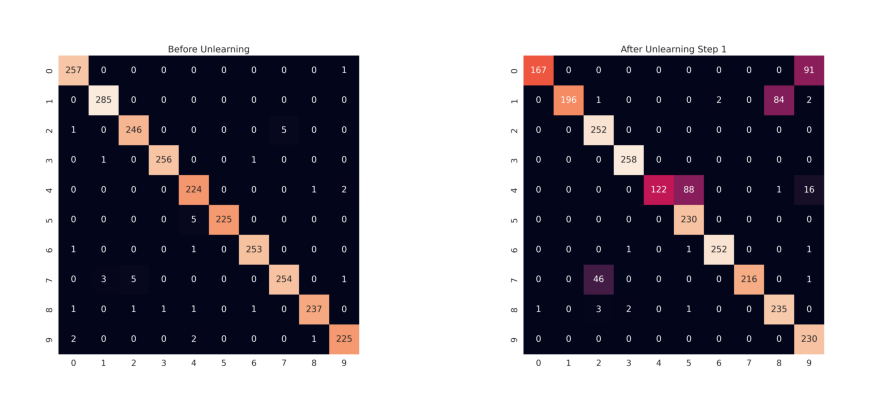

In [27]:
cm_before = mpimg.imread(poisoned_folder/'second-order'/'cm'/'cm_unlearning_00.png')
cm_after = mpimg.imread(poisoned_folder/'second-order'/'cm'/'cm_unlearning_01.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cm_before)
ax[1].imshow(cm_after)
ax[0].grid(False)
ax[1].grid(False)
ax[0].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
ax[1].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)

plt.show()

As you can see, the second-order unlearning is able to fix some of the missing accuracy. However, it can also be observed that the unlearning is not exact in the non-convex setting.

In [28]:
import json
import pandas as pd


with open(poisoned_folder/'first-order'/'unlearning_results.json', 'r') as f:
    results_fo = json.load(f) 

with open(poisoned_folder/'second-order'/'unlearning_results.json', 'r') as f:
    results_so = json.load(f) 
    
results = {}
results['first_order'] = results_fo['acc_after_fix']
results['second_order'] = results_so['acc_after_fix']
results['acc_before_fix'] = results_so['acc_before_fix']
results['acc_clean'] = results_so['acc_clean']
df = pd.DataFrame(results, index=[1])

In [ ]:
evaluate_and_save_results(dataset, modeltype, clean_weights, poisoned_weights, fo_repaired_weights, so_repaired_weights, BASE_DIR/'Evaluation')

In [14]:
df

,first_order,second_order,acc_before_fix,acc_clean
1,0.6804,0.8744,0.9848,0.7908


### RESNET50

In [3]:
import sys
sys.path.append('../')
# only if you are using CUDA devices
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from conf import BASE_DIR
from Applications.Poisoning.gen_configs import main as gen_configs
from Applications.Poisoning.train import main as train
from Applications.Poisoning.poison.poison_models import train_poisoned
from Applications.Poisoning.configs.demo.config import Config
from Applications.Poisoning.unlearn.first_order import run_experiment as fo_experiment
from Applications.Poisoning.unlearn.second_order import run_experiment as so_experiment
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import json
import pandas as pd


model_folder = BASE_DIR/'models'/'poisoning'
train_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'train.json'
poison_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'poison.json'
unlearn_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'unlearn.json'

gen_configs(model_folder, train_conf, poison_conf, unlearn_conf)

modeltype = "RESNET50"
# modeltype = VGG16
# modeltype = ResNet
# train one clean and one poisoned model
#dataset = 'Cifar10'
# dataset = 'Cifar100'
dataset = 'Mnist'
# classes = 10
classes100 = 100

#dataset = 'Mnist'
#train(model_folder=model_folder/'clean', dataset)
train(model_folder=model_folder/'clean', dataset=dataset, modeltype = modeltype, classes=classes100)

#Train Poisoned Model
poisoned_folder = model_folder/'budget-10000'/'seed-42'
poison_kwargs = Config.from_json(poisoned_folder/'poison_config.json')
train_kwargs = Config.from_json(poisoned_folder/'train_config.json')
train_poisoned(model_folder=poisoned_folder, poison_kwargs=poison_kwargs, train_kwargs=train_kwargs, dataset=dataset, modeltype="RESNET50", classes=classes100)


poisoned_weights = poisoned_folder/'best_model.hdf5'       # model that has been trained on poisoned data
fo_repaired_weights = poisoned_folder/'fo_repaired.hdf5'   # model weights after unlearning (first-order)
so_repaired_weights = poisoned_folder/'so_repaired.hdf5'   # model weights after unlearning (second-order)
injector_path = poisoned_folder/'injector.pkl'             # cached injector for reproducibility
clean_results = model_folder/'clean'/'train_results.json'  # path to reference results on clean dataset


2024-06-11 08:26:06.707582: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-11 08:26:06.707625: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: conite-HP
2024-06-11 08:26:06.707636: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: conite-HP
2024-06-11 08:26:06.707827: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 555.42.2
2024-06-11 08:26:06.707868: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 555.42.2
2024-06-11 08:26:06.707876: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 555.42.2
2024-06-11 08:26:06.708288: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100


KeyboardInterrupt: 

In [ ]:
fo_unlearn_kwargs = Config.from_json(poisoned_folder/'first-order'/'unlearn_config.json')
so_unlearn_kwargs = Config.from_json(poisoned_folder/'second-order'/'unlearn_config.json')

fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs, dataset=dataset, modeltype = "RESNET50", classes=classes100)
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs, dataset=dataset, modeltype = "RESNET50", classes=classes100)


# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8


cm_before = mpimg.imread(poisoned_folder/'first-order'/'cm'/'cm_unlearning_00.png')
cm_after = mpimg.imread(poisoned_folder/'first-order'/'cm'/'cm_unlearning_01.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cm_before)
ax[1].imshow(cm_after)
ax[0].grid(False)
ax[1].grid(False)
ax[0].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
ax[1].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)

plt.show()


cm_before = mpimg.imread(poisoned_folder/'second-order'/'cm'/'cm_unlearning_00.png')
cm_after = mpimg.imread(poisoned_folder/'second-order'/'cm'/'cm_unlearning_01.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cm_before)
ax[1].imshow(cm_after)
ax[0].grid(False)
ax[1].grid(False)
ax[0].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
ax[1].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)

plt.show()


with open(poisoned_folder/'first-order'/'unlearning_results.json', 'r') as f:
    results_fo = json.load(f) 

with open(poisoned_folder/'second-order'/'unlearning_results.json', 'r') as f:
    results_so = json.load(f) 
    
results = {}
results['first_order'] = results_fo['acc_after_fix']
results['second_order'] = results_so['acc_after_fix']
results['acc_before_fix'] = results_so['acc_before_fix']
results['acc_clean'] = results_so['acc_clean']
df = pd.DataFrame(results, index=[1])
print(df)
df.plot(kind='bar')